## Overview

This notebook enables tracking the performance of several mice across sessions for a set of behavioral parameters.

### Prerequisites

- The behavioral parameters must be saved in pickle files during the processing of foraging sessions with `Behavior_Analysis.ipynb`.

### Structure

This notebook is based on two main components:
1. **Data Loading**: Loads specified data from pickle files across sessions and animals using the `load_pickle_data` function, returning a data dictionary.
2. **Plot Generation**: Generates plots to visualize the performance metrics using the data dictionary


In [1]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt #Creation de graphiques et de visualisations comme matlab
from matplotlib.patches import Polygon #Creation de graphiques et de visualisations comme matlab
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.ndimage import gaussian_filter as smooth
#import gc
import glob
#import time
from behavior_analysis_functions import list_sessions_analyzed, \
                                    process_session, html_mouse, load_data, MOUSE_STRING


In [56]:
# the path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
# path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'

#path_to_data_folder='/home/david/Documents/David/Data/'

path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(path_to_data_folder + "/MOU*")]
mice_list=sorted(mice_list)
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = path_to_data_folder + mouse
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')








Found 8 mice in the data folder:
Hello, I'm MOU2329! I have foraged for 22 sessions:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Hello, I'm MOU2330! I have foraged for 22 sessions:
['MOU2330_20240607-1335', 'MOU2330_20240607-1733', 'MOU2330_20240610-0956', 'MOU2330_20240610-1357', 'MOU2330_20240611-0936', 'MOU2330_20240611-1342', 'MOU2330_20240612-0937', 'MOU2330_20240612-1400', 'MOU2330_20240613-0933', 'MOU2330_20240613-1424', 'MOU2330_20240614-0840', 'MOU2330_20240614-1351', 'MOU2330_

In [4]:
def trapezes_from_patch(patch, width):
    """
    generate the trapezes coordinates surrounding a patch
    inputs:
    patch - coordinates of a patch [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]]
    width - width of the trapeze in pixels
    outputs:
    coordinates [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]] for the 4 trapezes.
    
    trapezes_from_patch(SWpatch_coords, 200)
    """

    N = [patch[0], patch[1], [patch[1][0]+width, patch[1][1]+width], [patch[0][0]-width, patch[0][1]+width]]
    E = [patch[1], patch[2], [patch[2][0]+width, patch[2][1]-width], [patch[1][0]+width, patch[1][1]+width]]
    S = [patch[2], patch[3], [patch[3][0]-width, patch[3][1]-width], [patch[2][0]+width, patch[2][1]-width]]
    W = [patch[3], patch[0], [patch[0][0]-width, patch[0][1]+width], [patch[3][0]-width, patch[3][1]-width]]
    return N, E, S, W


RESOLUTION = 512, 512
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories
NWpatch_coords = [[104, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  201], [104, RESOLUTION[1] -  201]]
NEpatch_coords = [[330, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  200], [330, RESOLUTION[1] -  200]]
SWpatch_coords = [[109, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  410], [109, RESOLUTION[1] -  410]]
SEpatch_coords = [[330, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  410], [330, RESOLUTION[1] -  410]]

collection_trapeze = {"NW":dict(), "NE":dict(), "SW":dict(), "SE":dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)

## Playing with other movements stored in all_running_epochs.pkl

In [5]:
mice_list

['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']

In [6]:
session_list

{'MOU2329': ['MOU2329_20240620-0821',
  'MOU2329_20240618-1451',
  'MOU2329_20240607-1315',
  'MOU2329_20240611-1324',
  'MOU2329_20240620-1339',
  'MOU2329_20240621-1425',
  'MOU2329_20240607-1714',
  'MOU2329_20240611-0915',
  'MOU2329_20240621-0829',
  'MOU2329_20240617-0829',
  'MOU2329_20240610-1336',
  'MOU2329_20240612-0918',
  'MOU2329_20240610-0936',
  'MOU2329_20240613-1405',
  'MOU2329_20240617-1420',
  'MOU2329_20240619-1406',
  'MOU2329_20240614-0820',
  'MOU2329_20240614-1331',
  'MOU2329_20240618-0829',
  'MOU2329_20240612-1341',
  'MOU2329_20240619-0828',
  'MOU2329_20240613-0914'],
 'MOU2330': ['MOU2330_20240617-1438',
  'MOU2330_20240619-0846',
  'MOU2330_20240614-0840',
  'MOU2330_20240618-0848',
  'MOU2330_20240618-1509',
  'MOU2330_20240611-0936',
  'MOU2330_20240614-1351',
  'MOU2330_20240613-0933',
  'MOU2330_20240607-1335',
  'MOU2330_20240607-1733',
  'MOU2330_20240620-0838',
  'MOU2330_20240610-0956',
  'MOU2330_20240612-1400',
  'MOU2330_20240610-1357',
  'MO

In [7]:
path_to_data_folder

'/Users/davidrobbe/Documents/Science/Data/ForagingMice/'

In [ ]:
['MOU2329']['MOU2329_20240614-1331']

In [8]:
mouse_folder_path=os.path.join(path_to_data_folder,mice_list[0])
print(mouse_folder_path)

/Users/davidrobbe/Documents/Science/Data/ForagingMice/MOU2329


In [58]:
print(session_list[mice_list[0]][11])

MOU2329_20240614-1331


In [ ]:
traj_df, turns_df, param_df=load_data(mouse_folder_path,session_list[mice_list[0]][11])
# smooth the trajectory and correct for some open CV flipping
TRUE_SIGMA = 1 #the sigma used for the remaining of the analysis for smoothing
traject_time = traj_df['time'].to_numpy()
xpositions = traj_df['xposition'].to_numpy()
ypositions = traj_df['yposition'].to_numpy()
ypositions = RESOLUTION[1] - ypositions # yposition is inverted, puts it back in the right way. DAvid: this is not simply an inversion because resolution is added
smoothed_Xpositions = smooth(xpositions, TRUE_SIGMA)
smoothed_Ypositions = smooth(ypositions, TRUE_SIGMA) # Smoothes the positions with true sigma


def compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time):
    # Calculate the differences between consecutive points
    delta_x = np.diff(smoothed_Xpositions)
    delta_y = np.diff(smoothed_Ypositions)
    delta_t = np.diff(traject_time)
    
    # Compute the distances traveled between each timepoint
    distances = np.sqrt(delta_x**2 + delta_y**2)
    distances=distances*(84/RESOLUTION[0])
    
    # Compute the speeds between each timepoint
    speeds = distances / delta_t
    
    return distances, speeds


distances, speeds = compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time)

print("Distances:", distances)
print("Speeds:", speeds)

maxspeed=np.max(speeds[620:640])
print(maxspeed)
plt.plot(speeds)
plt.xlim([1000,2000])
plt.ylim([0,60])
plt.show()

# smooth the trajectory and correct for some open CV flipping
TRUE_SIGMA = 1 #the sigma used for the remaining of the analysis for smoothing
traject_time = traj_df['time'].to_numpy()
xpositions = traj_df['xposition'].to_numpy()
ypositions = traj_df['yposition'].to_numpy()
ypositions = RESOLUTION[1] - ypositions # yposition is inverted, puts it back in the right way. DAvid: this is not simply an inversion because resolution is added
smoothed_Xpositions = smooth(xpositions, TRUE_SIGMA)
smoothed_Ypositions = smooth(ypositions, TRUE_SIGMA) # Smoothes the positions with true sigma


def compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time):
    # Calculate the differences between consecutive points
    delta_x = np.diff(smoothed_Xpositions)
    delta_y = np.diff(smoothed_Ypositions)
    delta_t = np.diff(traject_time)
    
    # Compute the distances traveled between each timepoint
    distances = np.sqrt(delta_x**2 + delta_y**2)
    distances=distances*(84/RESOLUTION[0])
    
    # Compute the speeds between each timepoint
    speeds = distances / delta_t
    
    return distances, speeds


distances, speeds = compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time)

print("Distances:", distances)
print("Speeds:", speeds)

pathtopicklefolder=os.path.join(mouse_folder_path,session_list[mice_list[0]][11],'Pickle_data')
print(pathtopicklefolder)
# List all files in the current directory
os.chdir(pathtopicklefolder)
files_in_directory = os.listdir()

# Filter out the pickle files
pickle_files = sorted([file for file in files_in_directory if file.endswith('.pkl')])

# Print the list of pickle files
for pickle_file in pickle_files:
    print(pickle_file)

file_to_load = pickle_files[0]
print(f"\nLoading pickle file: {file_to_load}")

# Open and load the pickle file
with open(file_to_load, 'rb') as f:
    loaded_data = pickle.load(f)

# Print the loaded data to verify
print("\nLoaded data from the pickle file:")
print(loaded_data)
list_around_towers = [epoch for epoch in loaded_data if epoch[2][0] == "Q"]
list_between_towers = [epoch for epoch in loaded_data if epoch[2][0] == "B"]
list_toward_towers = [epoch for epoch in loaded_data if epoch[2][0] == "T"] # All trajectories towards objects
list_other_movements = [epoch for epoch in loaded_data if epoch[2][0] == "N"] # All other trajectories


def plot_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, runtype_epochs, collection_trapezea, q=4, runtype_name='same type of run'):
    fig, ax1 = plt.subplots(figsize=(10, 8))
    totaltime = 0
    totaldistance = 0
    meanspeed=[]
    maxspeed=[]
    
    distances, speeds = compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time)

    for patch in collection_trapeze:  # plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)

    for runtype_epoch in runtype_epochs:
        start_index, end_index = runtype_epoch[0], runtype_epoch[1]
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the run epoch, compute duration, distance and speed
        runtype_epoch_Xposition = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Yposition = smoothed_Ypositions[start_index:end_index + 1]
        epochduration = traject_time[end_index] - traject_time[start_index]
        totaltime += epochduration
        distanceran=np.sum(distances[start_index:end_index])
        totaldistance += distanceran
        meanspeed.append(distanceran / epochduration )
        maxspeed.append(np.max(speeds[start_index:end_index]))

        # Plot the trajectory
        ax1.plot(runtype_epoch_Xposition, runtype_epoch_Yposition, linestyle='-', label=f"Traj {start_index}-{end_index}")
        
        # Plot the start and end points
        ax1.plot(runtype_epoch_Xposition[0], runtype_epoch_Yposition[0], 'go', markersize=3)  # Start point
        #ax1.plot(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], 'ro', markersize=10)  # End point

        # Compute the direction of the arrow using the last q points
        if len(runtype_epoch_Xposition) >= q:
            dx = runtype_epoch_Xposition[-1] - runtype_epoch_Xposition[-q]
            dy = runtype_epoch_Yposition[-1] - runtype_epoch_Yposition[-q]
            
            # Normalize the direction
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            
            # Plot the arrow
            ax1.arrow(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], dx, dy,
                      head_width=6, head_length=5, fc='red', ec='red')
    
    print(maxspeed)
    print(np.median(maxspeed))
    print(meanspeed)
    # Set the title including the total duration
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title(f"{runtype_name} (Tot. Duration: {totaltime:.2f}s.; Tot. Distance: {totaldistance:.2f}cm; Mean speed: {np.mean(meanspeed):.2f}cm/s; Max speed: {np.mean(maxspeed):.2f}cm/s)")
    ax1.grid(True)
    # ax1.legend()
    plt.show()



plot_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, list_between_towers,collection_trapeze, runtype_name='runs between towers', q=4)

plot_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, list_around_towers,collection_trapeze, runtype_name='Runs around towers', q=4)

plot_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, list_toward_towers,collection_trapeze, runtype_name='runs toward towers', q=4)

plot_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, list_other_movements,collection_trapeze, runtype_name='other runs', q=4)
around_towers = [epoch for epoch in loaded_data if epoch[2][0] == "Q"]
between_towers = [epoch for epoch in loaded_data if epoch[2][0] == "B"]
toward_towers = [epoch for epoch in loaded_data if epoch[2][0] == "T"] # All trajectories towards objects
other_runs = [epoch for epoch in loaded_data if epoch[2][0] == "N"] # All other trajectories
runtypes=[around_towers,between_towers,toward_towers,other_runs]
runtypes_names=['around_towers','between_towers','toward_towers','other_runs']


def analyse_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, runtype_epochs):
    totaltime = 0
    totaldistance = 0
    meanspeed=[]
    maxspeed=[]
    
    distances, speeds = compute_distance_and_speed(smoothed_Xpositions, smoothed_Ypositions, traject_time)


    for runtype_epoch in runtype_epochs:
        start_index, end_index = runtype_epoch[0], runtype_epoch[1]
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the run epoch, compute duration, distance and speed
        epochduration = traject_time[end_index] - traject_time[start_index]
        totaltime += epochduration
        distanceran=np.sum(distances[start_index:end_index])
        totaldistance += distanceran
        meanspeed.append(distanceran / epochduration)
        maxspeed.append(np.max(speeds[start_index:end_index]))

        
    
    return totaltime,totaldistance,meanspeed, maxspeed
   


# Initialize an empty dictionary to store the results
runtypes_basic_kinematics = {}

# Loop through runtypes and runtypes_names in parallel
for runtype, runtype_name in zip(runtypes, runtypes_names):
    # Perform the analysis
    totaltime, totaldistance, meanspeed, maxspeed = analyse_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, runtype)
    
    # Store the results in the dictionary using descriptive keys
    runtypes_basic_kinematics[runtype_name] = {
        'total_time': totaltime,
        'total_distance': totaldistance,
        'mean_speed': meanspeed,
        'max_speed': maxspeed
    }

# Now you can access the results in the dictionary
print(runtypes_basic_kinematics)


In [101]:
np.median(runtypes_basic_kinematics['around_towers']['max_speed'])

np.float64(37.186293804538025)

In [47]:
mice_list

['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']

In [48]:

def load_pickled_data(path_to_data_folder, mice_list, pickle_files):
    data = {}

    for mouse in mice_list:
        mouse_folder = os.path.join(path_to_data_folder, mouse)
        if not os.path.isdir(mouse_folder):
            print(f"Mouse folder not found: {mouse_folder}")
            continue
        
        data[mouse] = {}

        session_folders = [folder for folder in os.listdir(mouse_folder) 
                           if folder.startswith('MOU') and os.path.isdir(os.path.join(mouse_folder, folder))]
        session_folders=sorted(session_folders)

        for session_folder in session_folders:
            session_folder_path = os.path.join(mouse_folder, session_folder)
            pickle_data_folder = os.path.join(session_folder_path, 'Pickle_data')

            if not os.path.isdir(pickle_data_folder):
                print(f"Pickle_data folder not found in {session_folder_path}")
                continue
            
            data[mouse][session_folder] = {}

            for pickle_file in pickle_files:
                pickle_file_path = os.path.join(pickle_data_folder, pickle_file)
                
                if not os.path.isfile(pickle_file_path):
                    print(f"Pickle file not found: {pickle_file_path}")
                    continue
                
                try:
                    with open(pickle_file_path, 'rb') as pf:
                        loaded_data = pickle.load(pf)
                        pickle_file_name = os.path.splitext(pickle_file)[0]

                        # Store loaded data in data dictionary
                        if pickle_file_name not in data[mouse][session_folder]:
                            data[mouse][session_folder][pickle_file_name] = loaded_data
                        else:
                            print(f"Warning: {pickle_file_name} already exists in {session_folder}")

                        # Calculate tower visits and mean QT per visit
                        # if pickle_file_name == 'consecutive_quarter_turns':
                        #     tower_visits = loaded_data
                        #     nber_of_tower_visits = len(tower_visits)
                        #     mean_nber_of_QT_per_visit = np.mean([visit[3] for visit in tower_visits])
                            
                        #     data[mouse][session_folder]['nber_of_tower_visits'] = nber_of_tower_visits
                        #     data[mouse][session_folder]['mean_nber_of_QT_per_visit'] = mean_nber_of_QT_per_visit
                        
                        # Calculate tower visits and mean QT per visit
                        # if pickle_file_name == 'speed_profile_qt':
                        #     speedprofile = loaded_data
                        #     max_runningspeed = max(speedprofile[1])
                        #     #mean_nber_of_QT_per_visit = np.mean([visit[3] for visit in tower_visits])
                            
                        #     data[mouse][session_folder]['max_runningspeed'] = max_runningspeed
                        #     #data[mouse][session_folder]['mean_nber_of_QT_per_visit'] = mean_nber_of_QT_per_visit

                except Exception as e:
                    print(f"Error loading pickle file {pickle_file_path}: {e}")

    return data

# # Example usage
# path_to_data_folder = '/home/david/Documents/David/Data/'
# mice_list = ['MOU2334']  # List of mice names
# pickle_files = ['distance_traveled.pkl', 'consecutive_quarter_turns.pkl']  # List of pickle files to load
# data = load_pickled_data(path_to_data_folder, mice_list, pickle_files)

# # Accessing the calculated metrics for a specific session
# session_data = data['MOU2334']['MOU2334_20240607-1213']
# nber_of_tower_visits = session_data['nber_of_tower_visits']
# mean_nber_of_QT_per_visit = session_data['mean_nber_of_QT_per_visit']

# print(f"Number of tower visits: {nber_of_tower_visits}")
# print(f"Mean number of QT per visit: {mean_nber_of_QT_per_visit}")


In [102]:
# run the load_pickled_data with a set of pickle files and some mice
pickle_files = ['all_running_epochs.pkl']  # List of pickle files to load
data = load_pickled_data(path_to_data_folder, mice_list, pickle_files)

In [103]:
data['MOU2329']['MOU2329_20240614-1331']

{'all_running_epochs': [[0, 49, 'BSENEn', np.int64(4)],
  [51, 200, 'N', np.int64(7)],
  [272, 316, 'N', 0],
  [330, 353, 'TSE', 0],
  [357, 376, 'QwGSER', np.int64(8)],
  [392, 431, 'N', np.int64(10)],
  [441, 461, 'QwDSER', np.int64(11)],
  [463, 478, 'QwGSER', np.int64(11)],
  [489, 505, 'QwDSER', np.int64(12)],
  [522, 559, 'BSENEn', np.int64(12)],
  [574, 599, 'QkGNER', np.int64(13)],
  [623, 640, 'QkGNER', np.int64(14)],
  [649, 668, 'QkDNER', np.int64(15)],
  [683, 702, 'QkGNER', np.int64(15)],
  [745, 801, 'BNESEn', np.int64(16)],
  [804, 823, 'QwGSER', np.int64(17)],
  [832, 849, 'QwGSER', np.int64(18)],
  [856, 875, 'N', 0],
  [877, 891, 'TNE', np.int64(19)],
  [906, 923, 'QkGNER', np.int64(20)],
  [973, 998, 'BNENWn', np.int64(22)],
  [1002, 1023, 'QkGNWR', np.int64(23)],
  [1033, 1054, 'QkGNWR', np.int64(24)],
  [1059, 1093, 'BNWNEn', np.int64(25)],
  [1115, 1138, 'BNESEn', np.int64(26)],
  [1177, 1186, 'QkBSER', np.int64(27)],
  [1193, 1211, 'QkBSER', np.int64(27)],
  [121

In [104]:
traj_df, turns_df, param_df=load_data(mouse_folder_path,session_list[mice_list[0]][11])
# smooth the trajectory and correct for some open CV flipping
TRUE_SIGMA = 1 #the sigma used for the remaining of the analysis for smoothing
traject_time = traj_df['time'].to_numpy()
xpositions = traj_df['xposition'].to_numpy()
ypositions = traj_df['yposition'].to_numpy()
ypositions = RESOLUTION[1] - ypositions # yposition is inverted, puts it back in the right way. DAvid: this is not simply an inversion because resolution is added
smoothed_Xpositions = smooth(xpositions, TRUE_SIGMA)
smoothed_Ypositions = smooth(ypositions, TRUE_SIGMA) # Smoothes the positions with true sigma

In [105]:
run_epochs_kinematics={}
for mouse, sessions_data in data.items():
    run_epochs_kinematics[mouse]={}
    # Enumerate through the sorted session keys
    for session in sorted(sessions_data.keys()):

        #load the trajectory
        mouse_folder_path=os.path.join(path_to_data_folder,mouse)
        traj_df, turns_df, param_df=load_data(mouse_folder_path,session)
        traject_time = traj_df['time'].to_numpy()
        xpositions = traj_df['xposition'].to_numpy()
        ypositions = traj_df['yposition'].to_numpy()
        ypositions = RESOLUTION[1] - ypositions # yposition is inverted, puts it back in the right way. DAvid: this is not simply an inversion because resolution is added
        smoothed_Xpositions = smooth(xpositions, TRUE_SIGMA)
        smoothed_Ypositions = smooth(ypositions, TRUE_SIGMA)


        #get the all the running epochs information for data dictionary 
        run_epochs_kinematics[mouse][session]={}
        
        allrunning_epochs=data[mouse][session]['all_running_epochs']
        
        around_towers = [epoch for epoch in allrunning_epochs if epoch[2][0] == "Q"]
        between_towers = [epoch for epoch in allrunning_epochs if epoch[2][0] == "B"]
        toward_towers = [epoch for epoch in allrunning_epochs if epoch[2][0] == "T"] # All trajectories towards objects
        other_runs = [epoch for epoch in allrunning_epochs if epoch[2][0] == "N"] # All other trajectories
        runtypes=[around_towers,between_towers,toward_towers,other_runs]
        runtypes_names=['around_towers','between_towers','toward_towers','other_runs']

        # Loop through runtypes, get the trajectories of the runtype and compute basic kinematics  
        for runtype, runtype_name in zip(runtypes, runtypes_names):
            # Perform the analysis
            totaltime, totaldistance, meanspeed, maxspeed = analyse_run_type(traject_time, smoothed_Xpositions, smoothed_Ypositions, runtype)
            
            # Store the results in the dictionary using descriptive keys
            run_epochs_kinematics[mouse][session][runtype_name] = {
                'total_time': totaltime,
                'total_distance': totaldistance,
                'mean_speed': meanspeed,
                'max_speed': maxspeed
    }

Indexes out of bounds for runtype_epoch: [-1, 43, 'TSE', 0]


In [106]:

np.median(run_epochs_kinematics['MOU2329']['MOU2329_20240614-1331']['around_towers']['max_speed'])

np.float64(37.186293804538025)

In [109]:
for mouse, sessions_data in run_epochs_kinematics.items():
    print(sessions_data)

{'MOU2329_20240607-1315': {'around_towers': {'total_time': np.float64(6.157999999999959), 'total_distance': np.float64(90.90296535979479), 'mean_speed': [np.float64(10.819686542355601), np.float64(17.941639807130386), np.float64(12.03637798902634), np.float64(13.281854929393232), np.float64(11.729563585351721), np.float64(15.755501702729653), np.float64(17.40158056407674), np.float64(12.777694499916537), np.float64(19.104329733216755), np.float64(20.00769365798535)], 'max_speed': [np.float64(15.86130201575853), np.float64(24.461276378765962), np.float64(18.482304399645777), np.float64(22.99647618129676), np.float64(27.214999783778218), np.float64(26.5608029903048), np.float64(26.124630741800146), np.float64(18.735422599207805), np.float64(28.912596339919556), np.float64(32.932811385678455)]}, 'between_towers': {'total_time': np.float64(11.125999999999976), 'total_distance': np.float64(225.28525049285508), 'mean_speed': [np.float64(22.042143764772533), np.float64(19.793223859081277), np

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_69662/4157483222.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


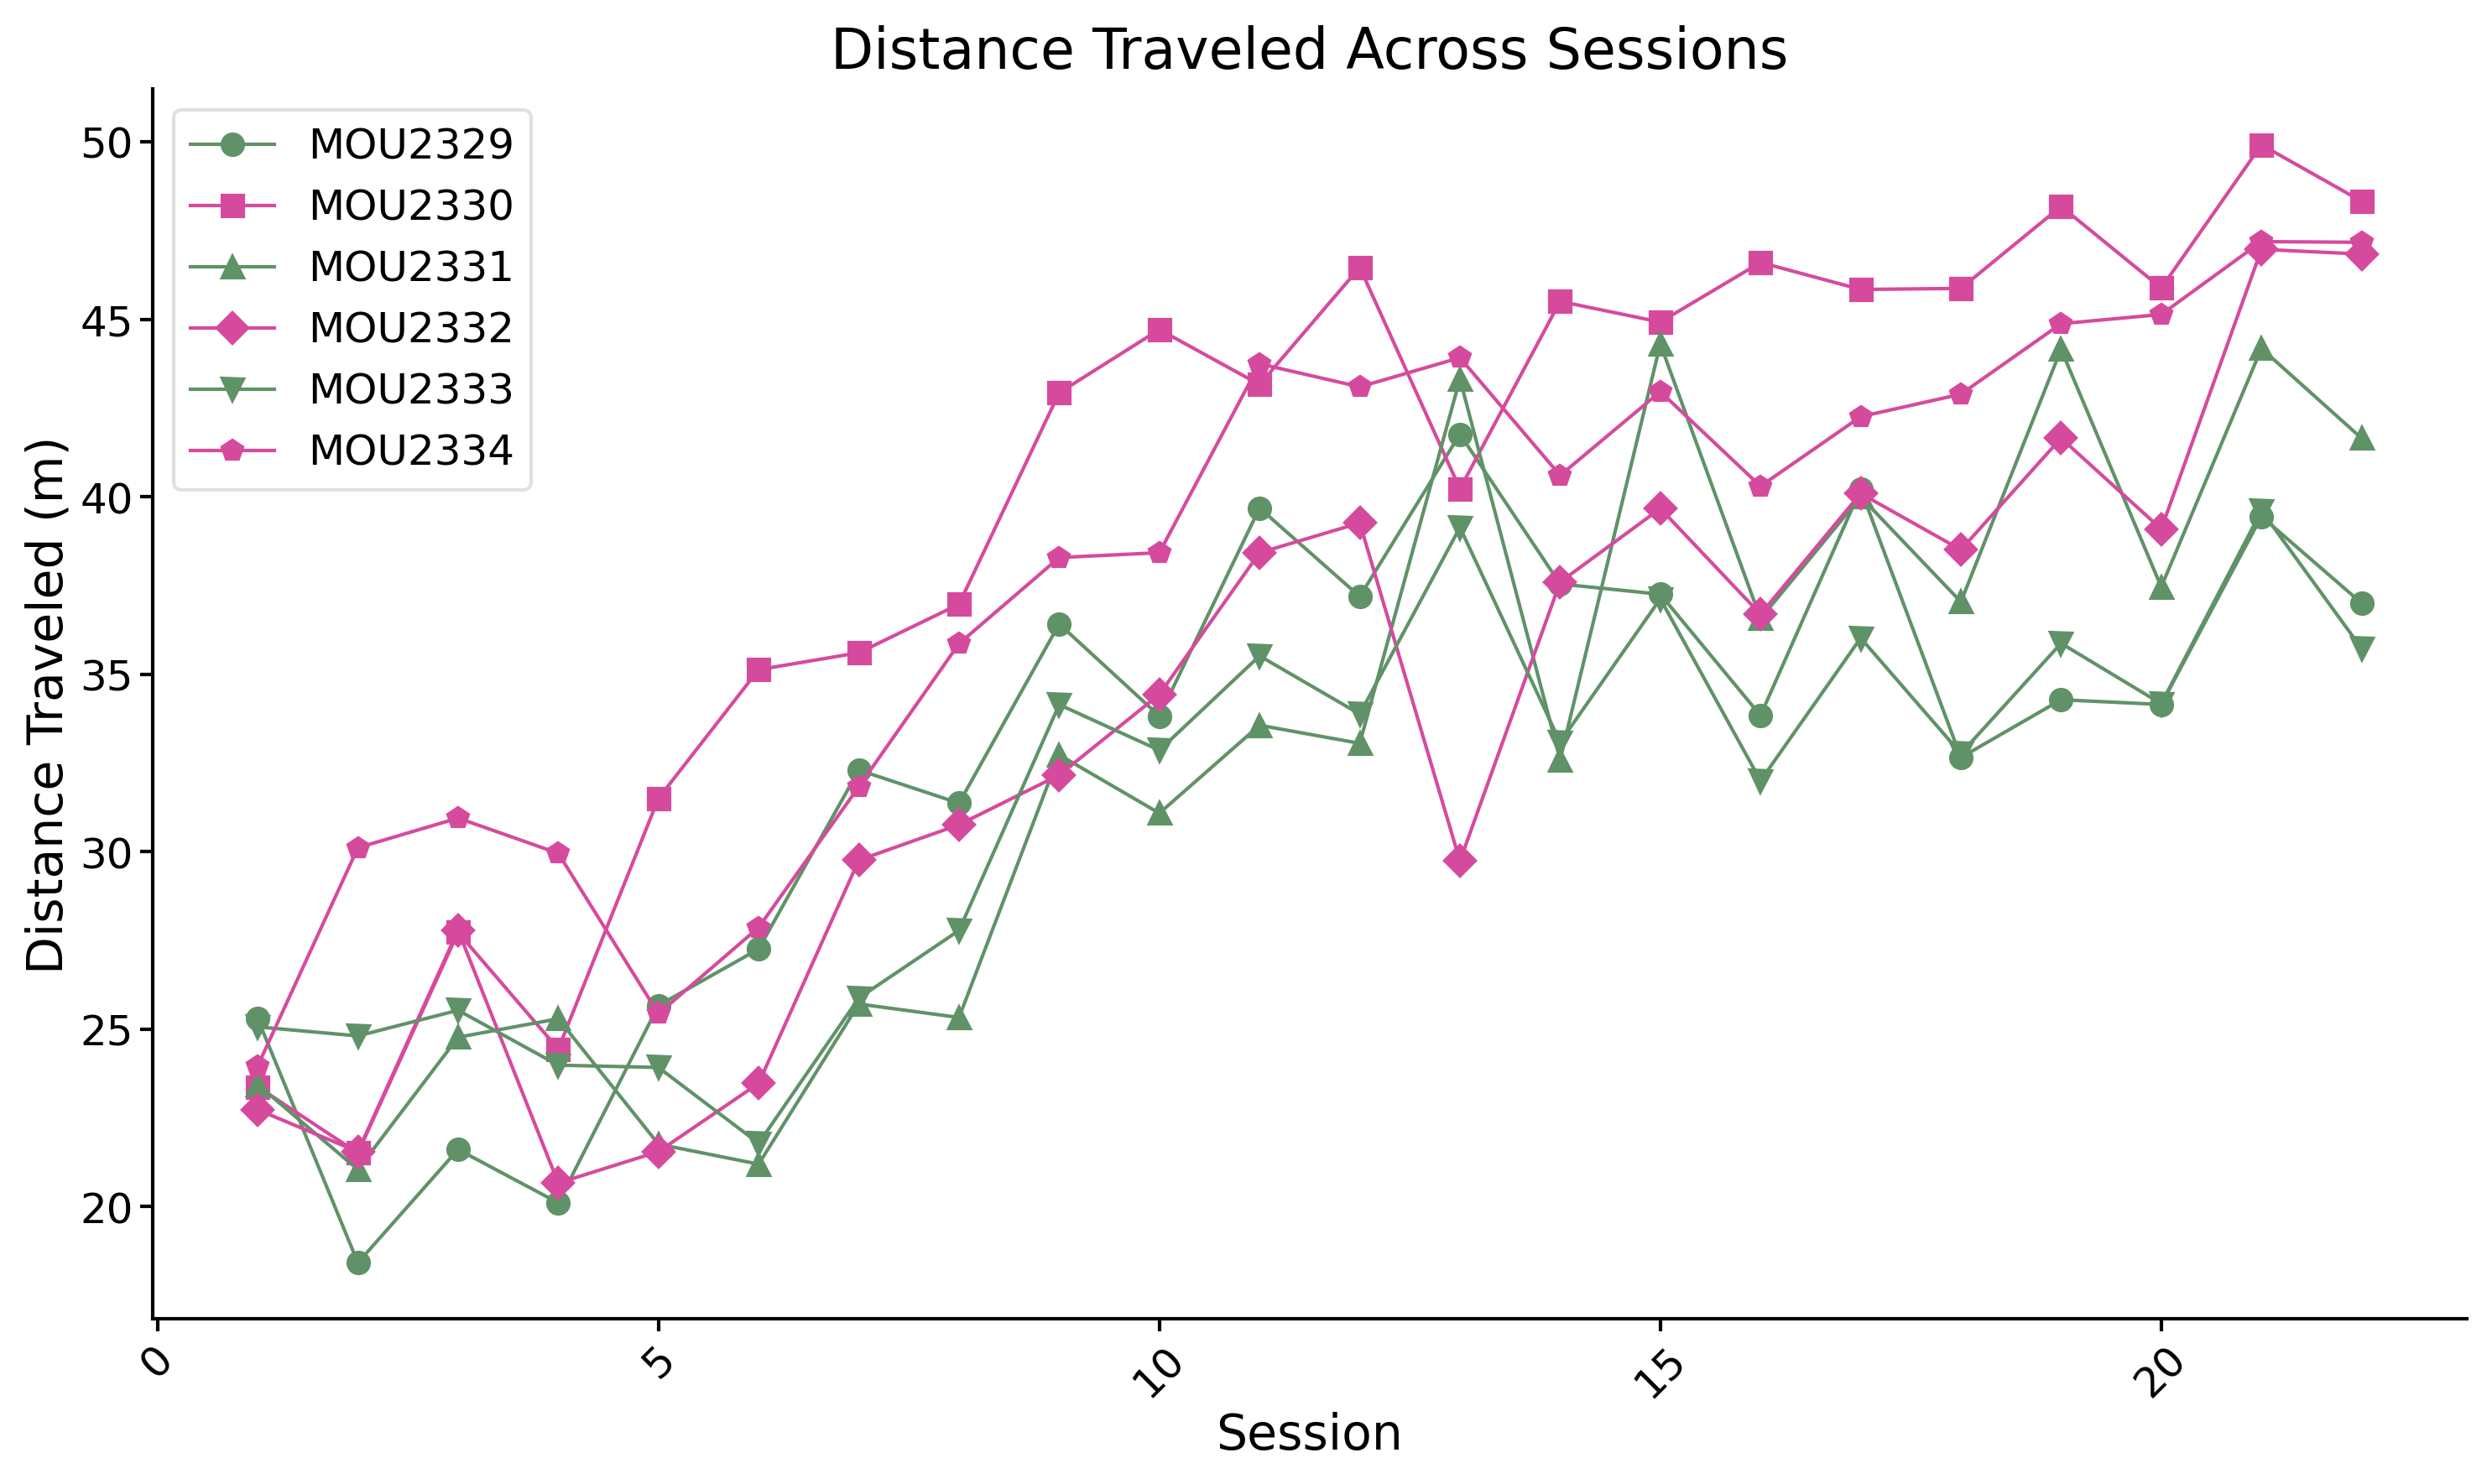

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_69662/4157483222.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


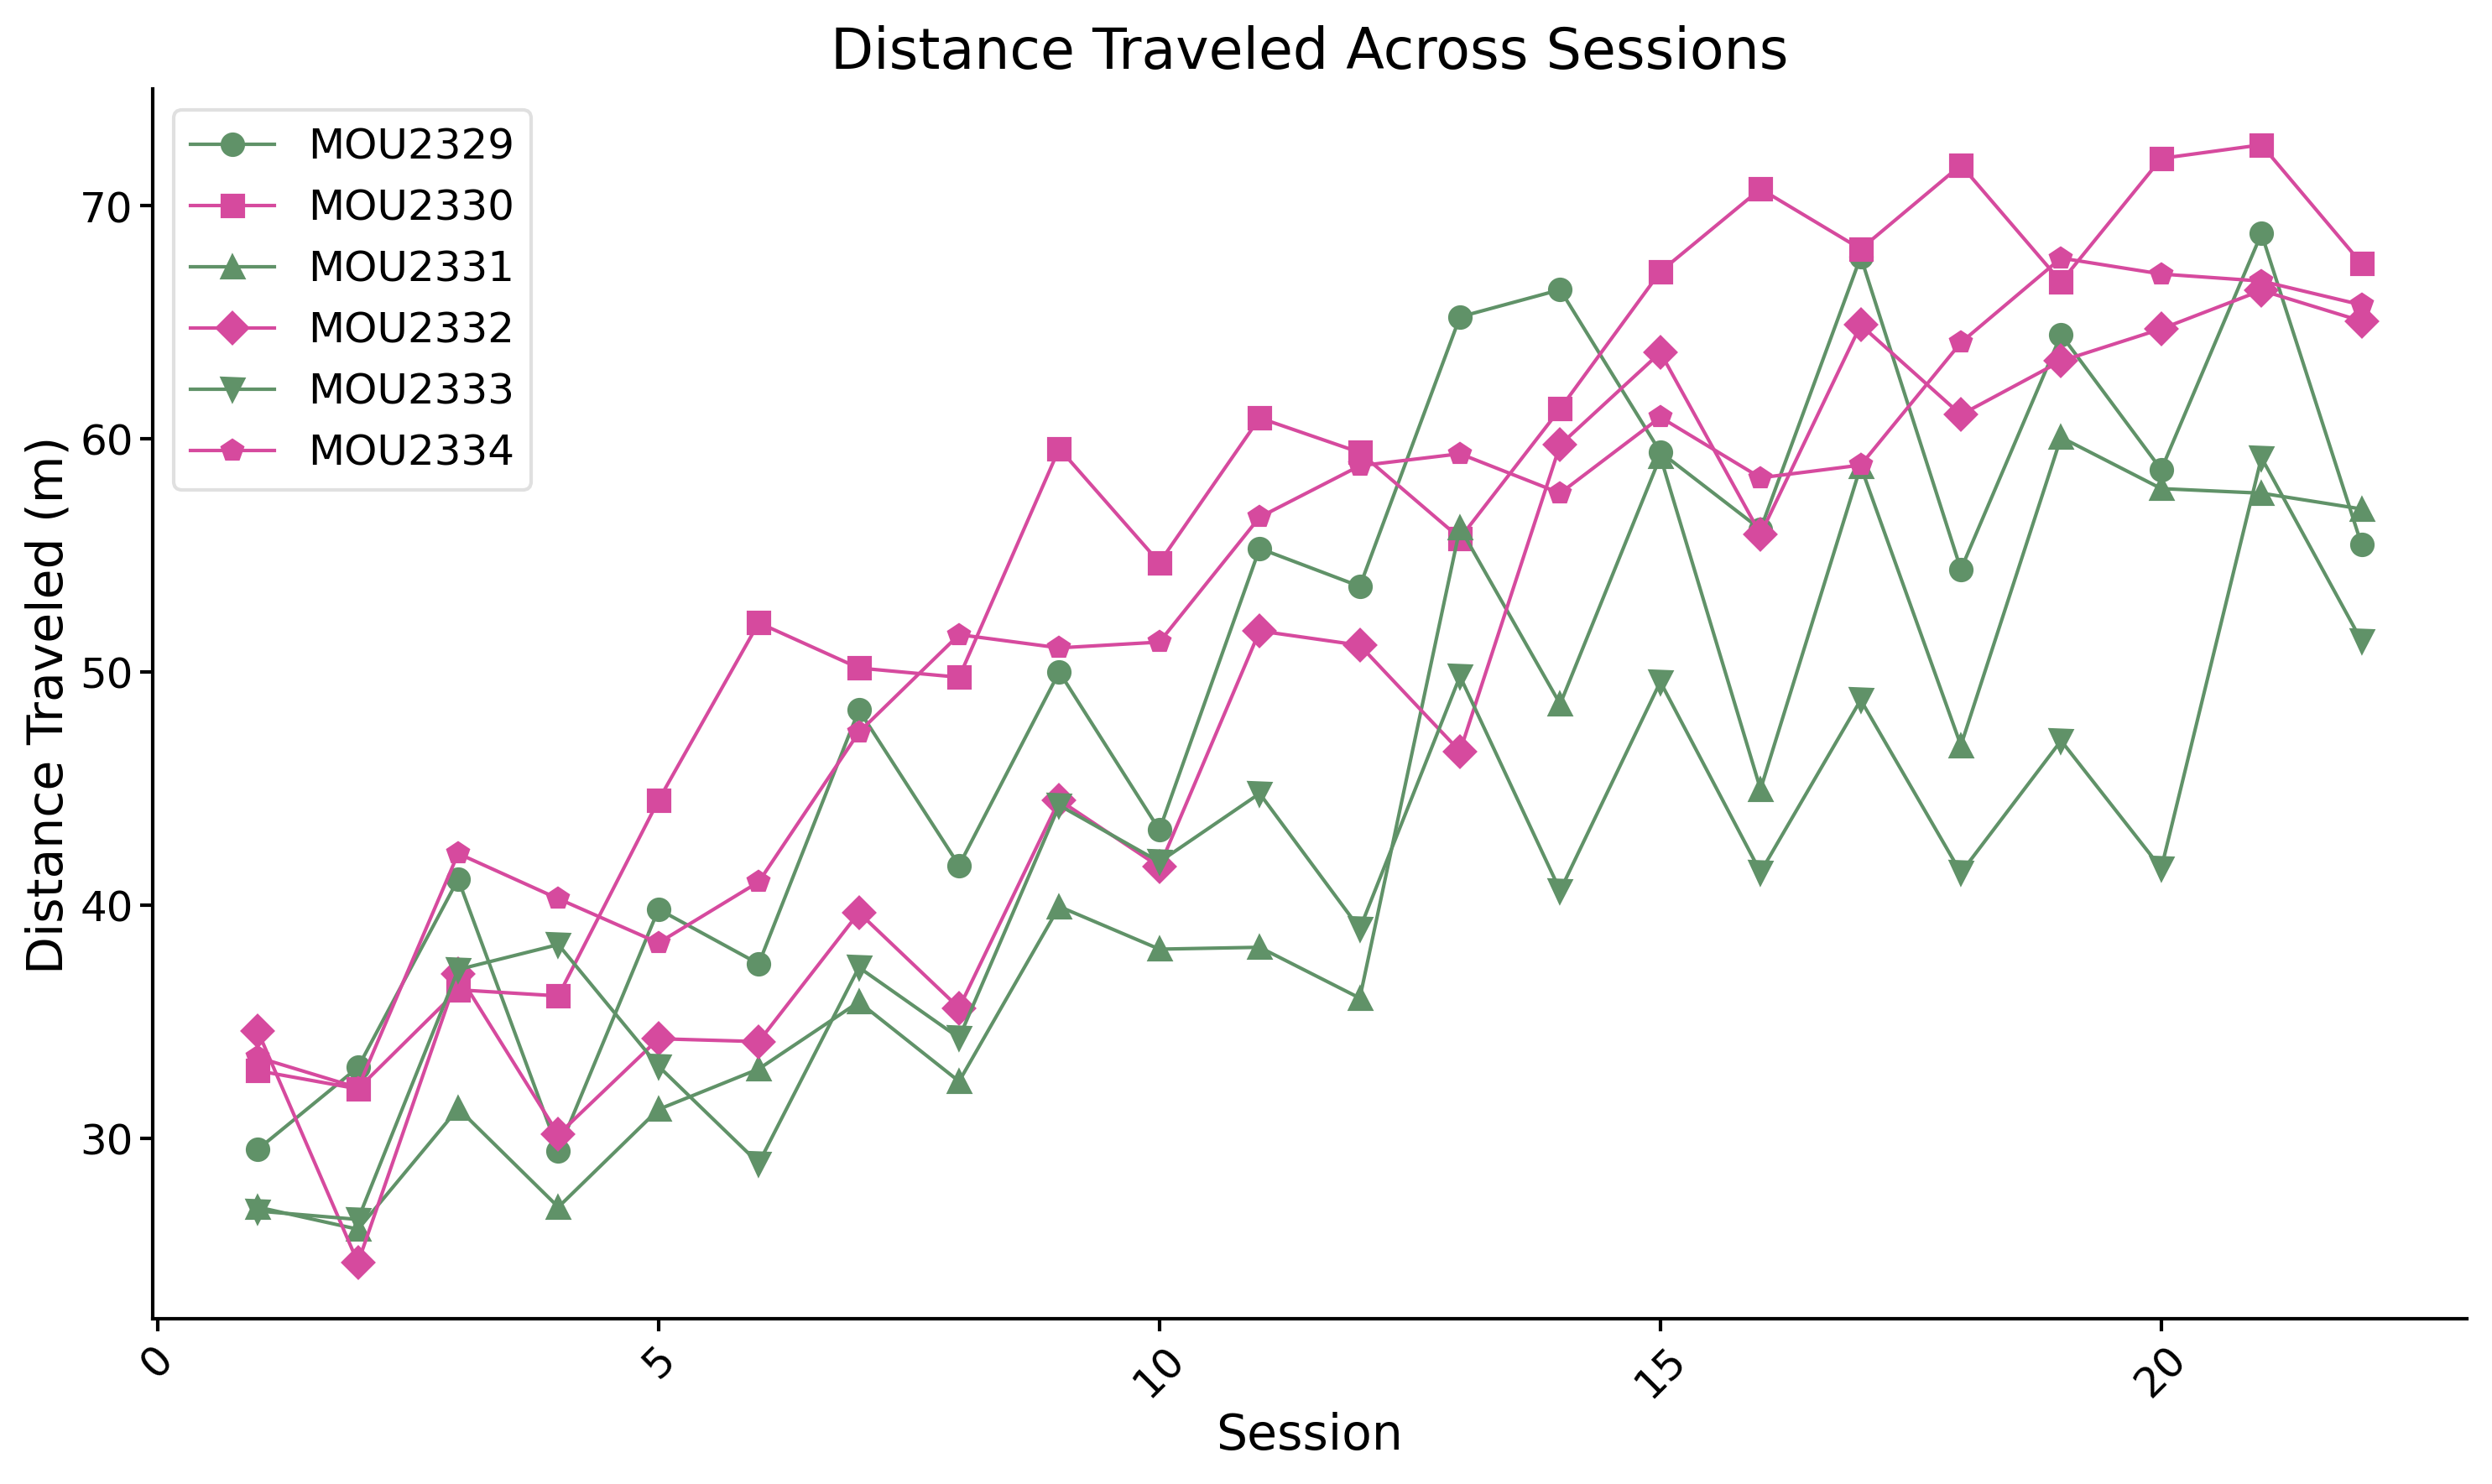

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_69662/4157483222.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


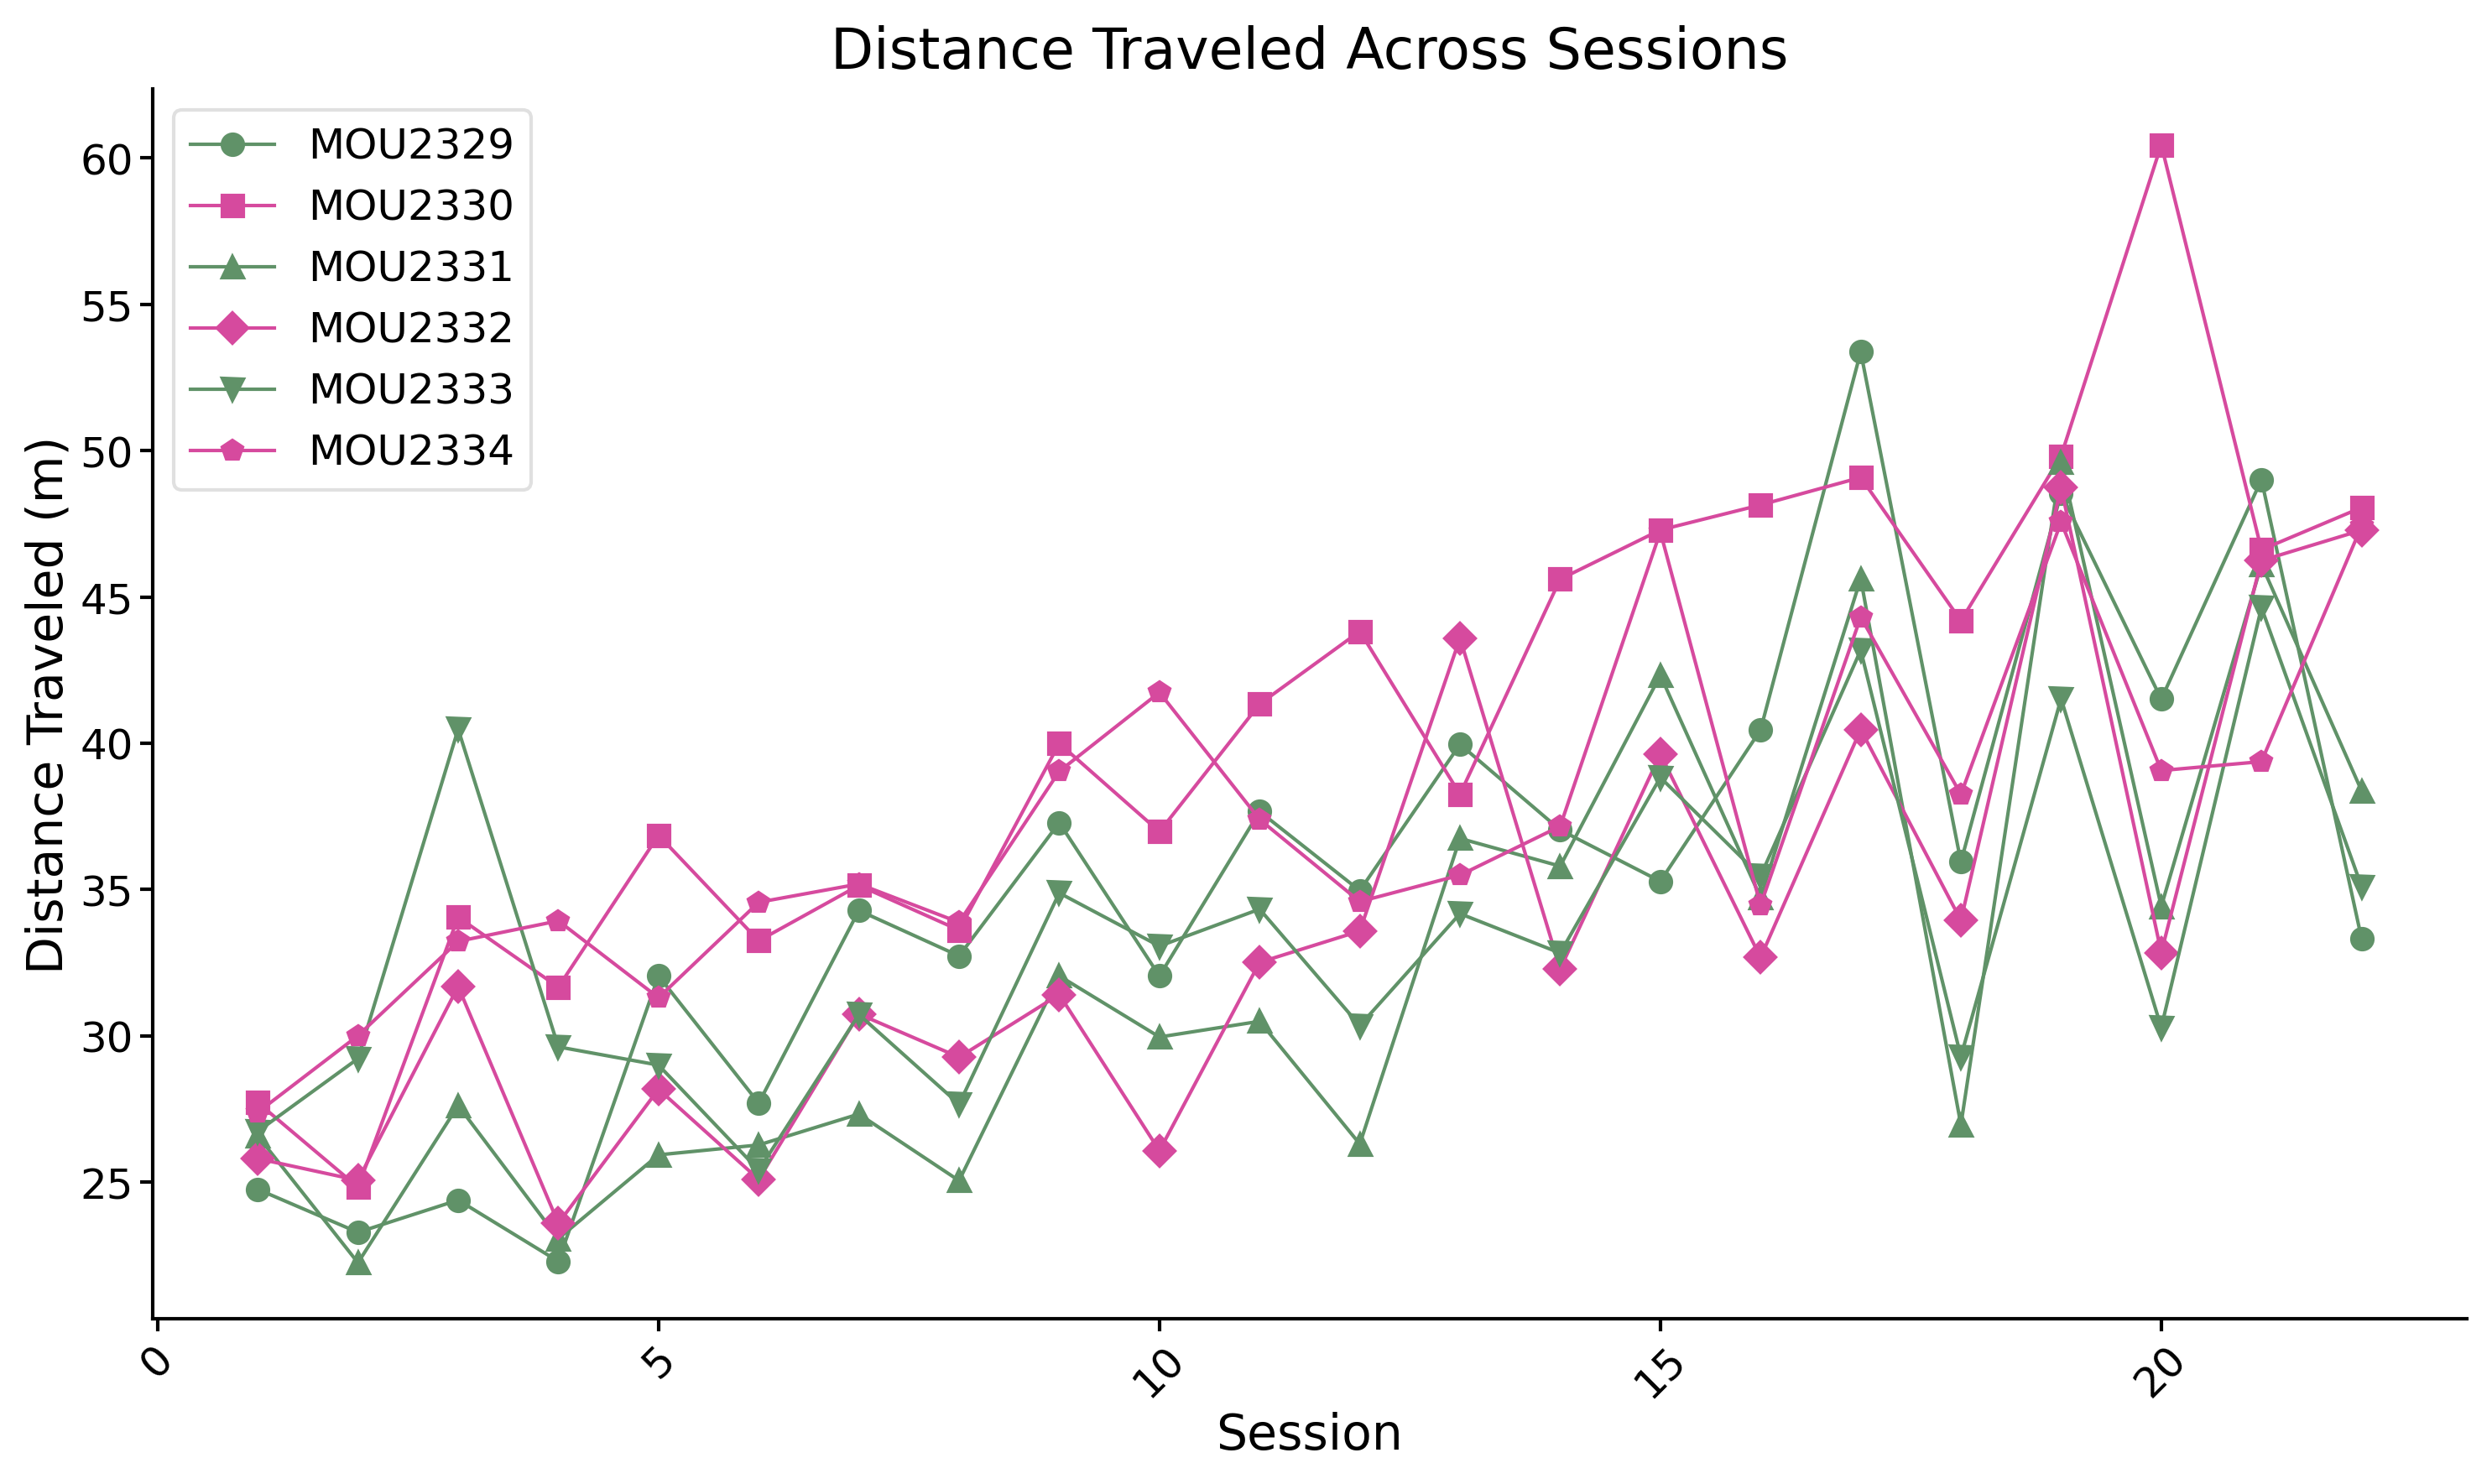

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_69662/4157483222.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


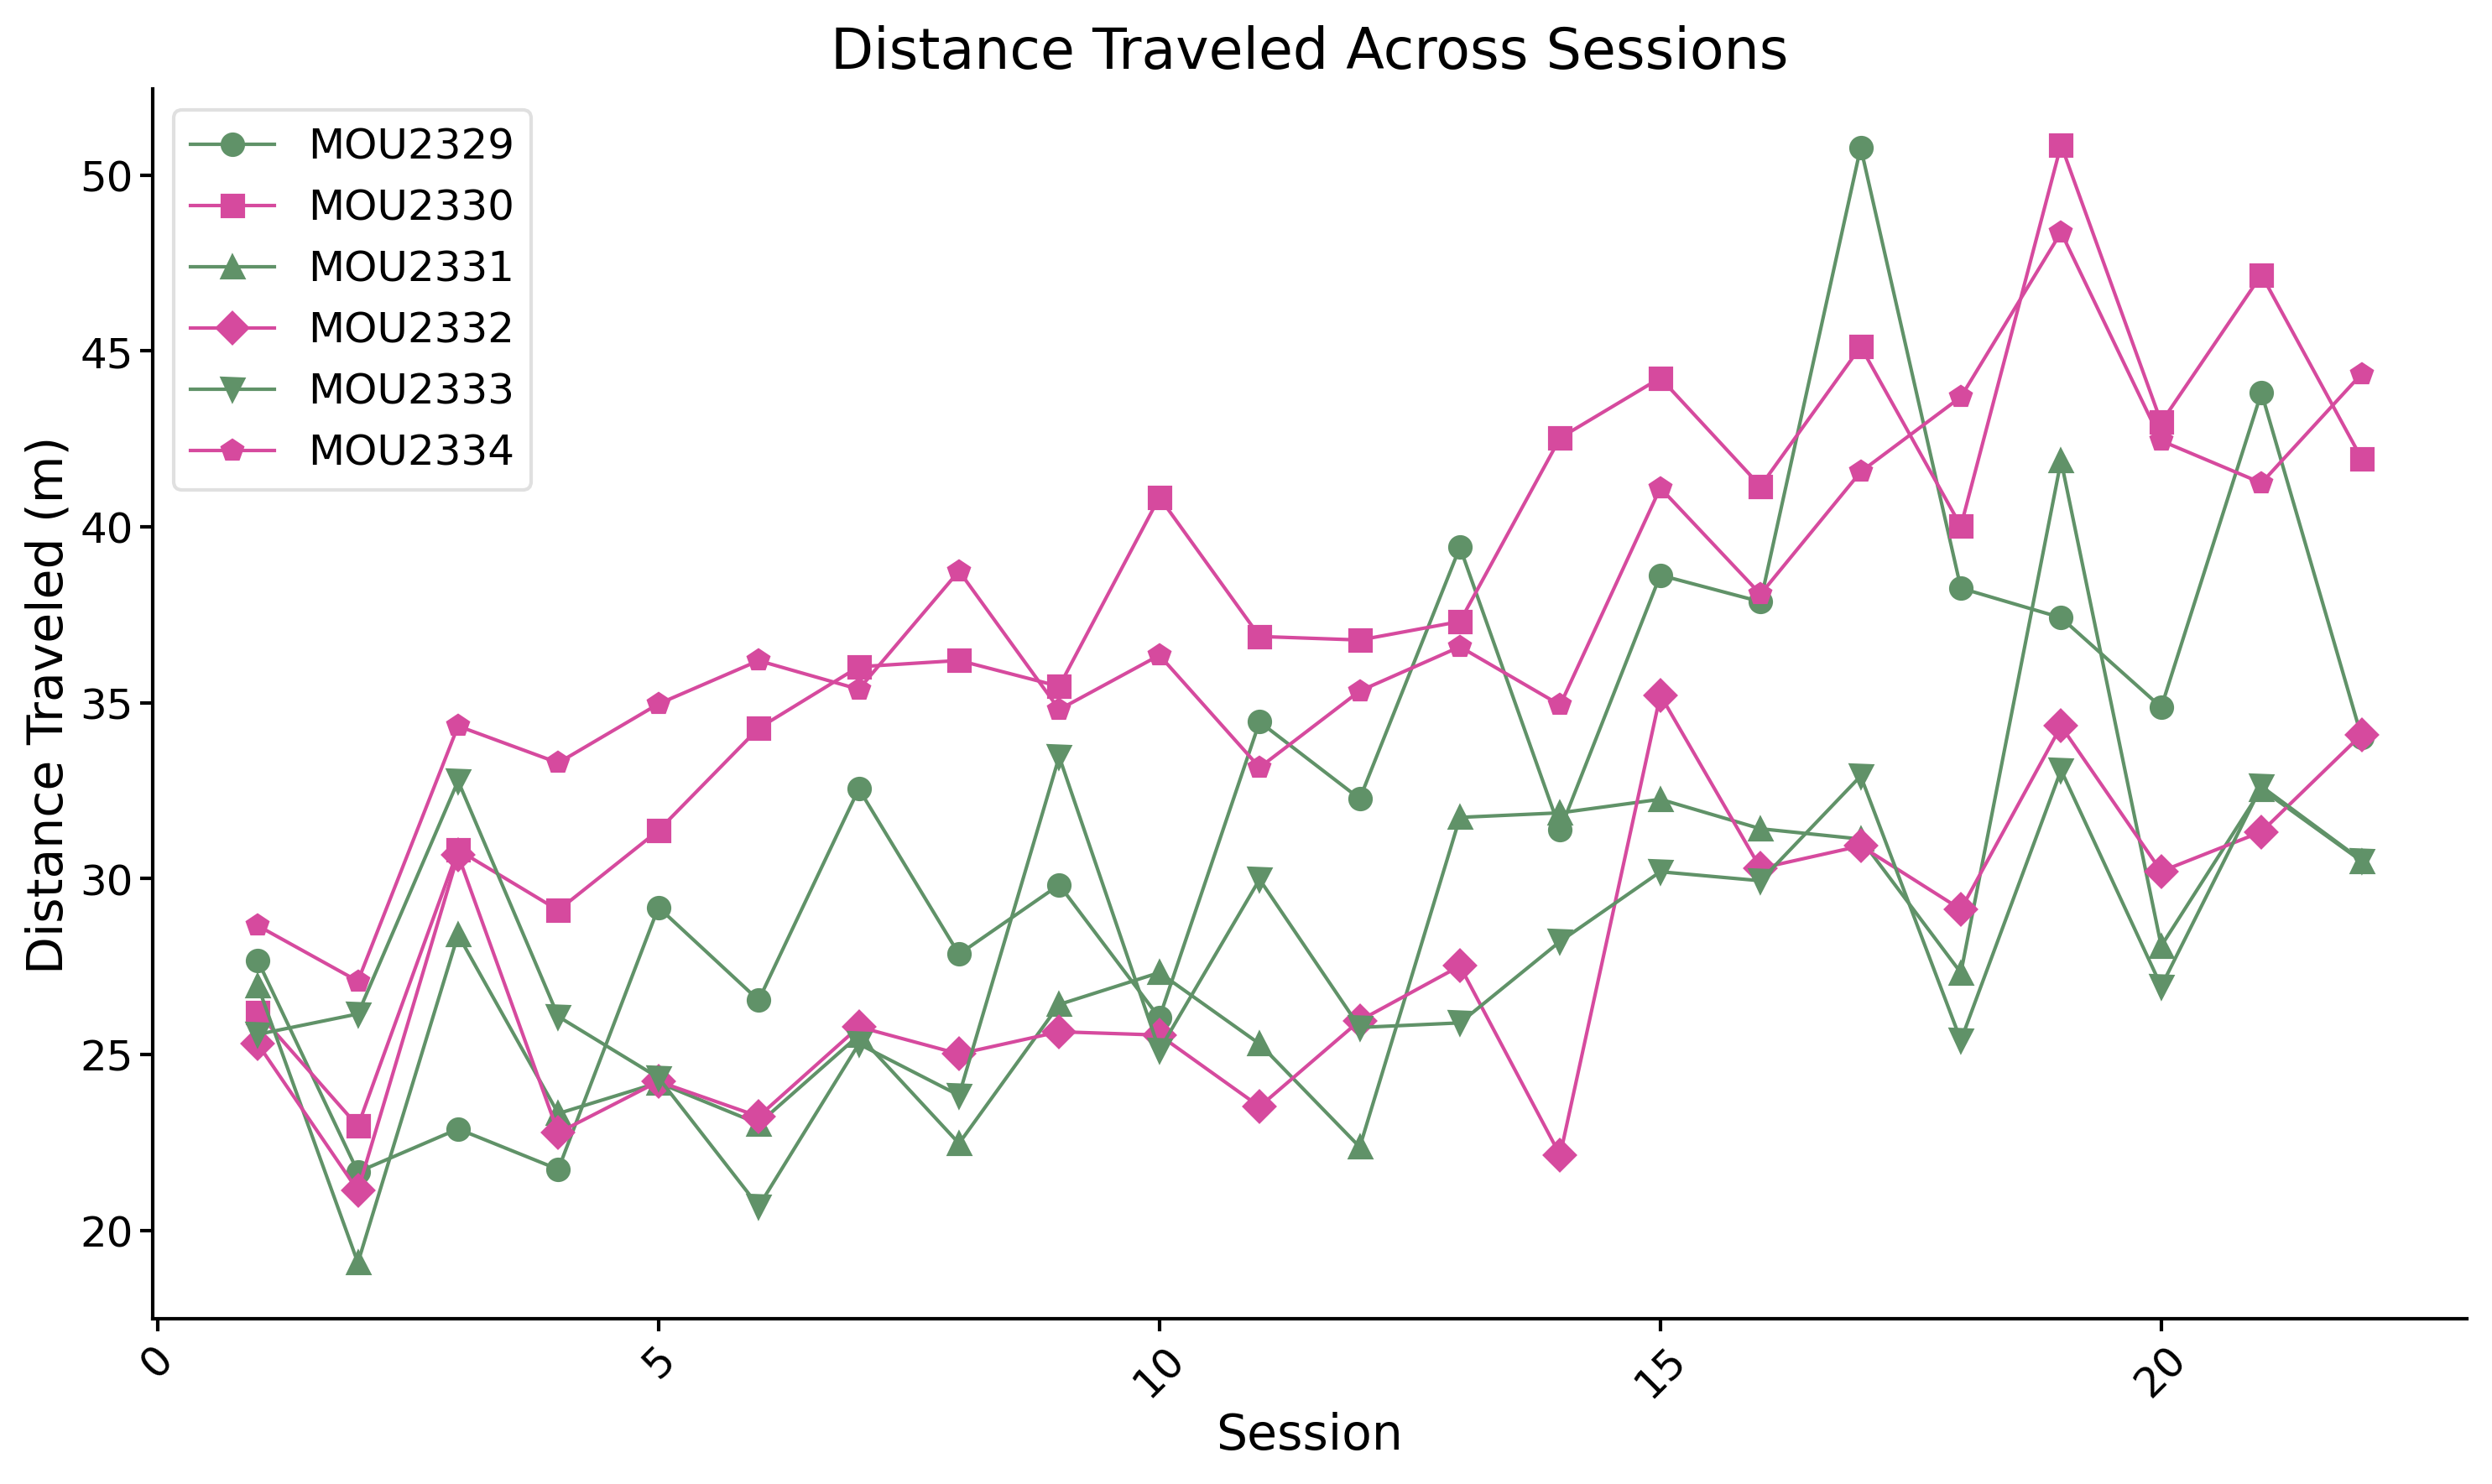

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_69662/4157483222.py:130: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


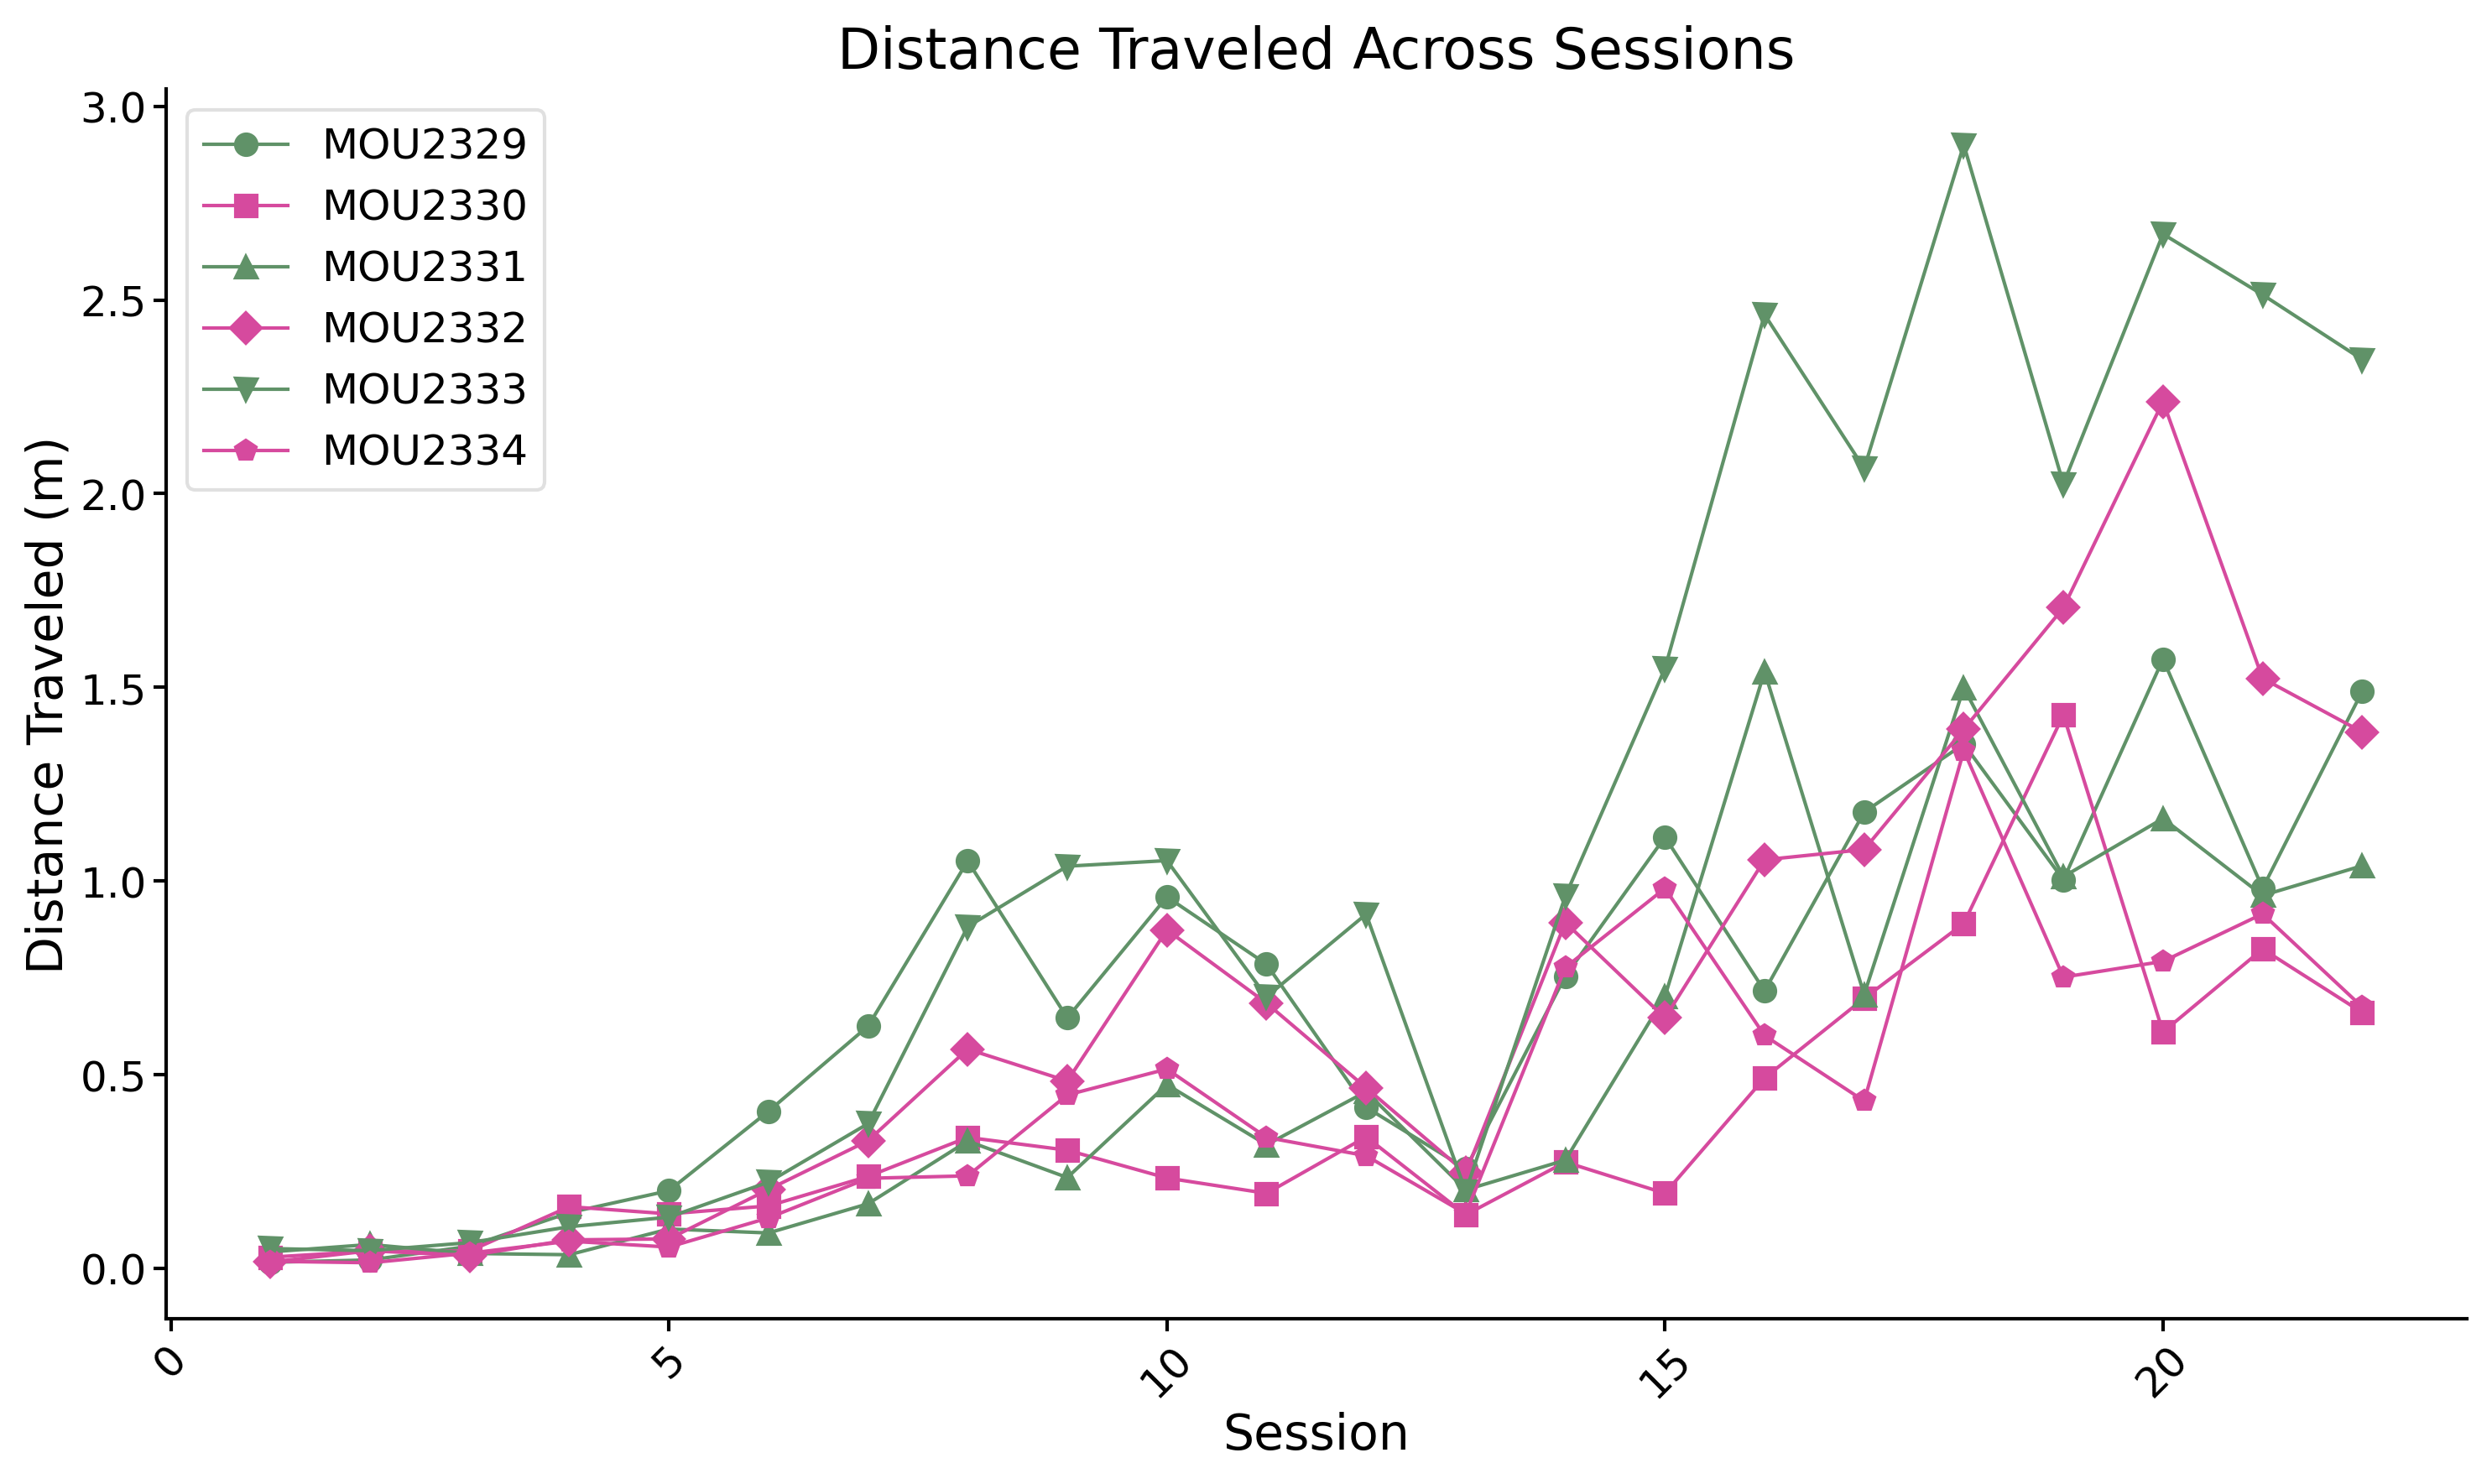

In [124]:
# this cell plots 5 behavioral features across animals and session. 
# If you want to plot something else fine but share it with others 



# Mapping odd and even mice names to colors
mice_colors = {}
for idx, mouse in enumerate(['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']):
    if idx % 2 == 0:
        mice_colors[mouse] = '#609268'
    else:
        mice_colors[mouse] = '#D64A9E'

# List of markers to use for different mice
markers = ['o', 's', '^', 'D', 'v', 'p']

# Mapping mice to markers
mice_markers = {}
for idx, mouse in enumerate(['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']):
    mice_markers[mouse] = markers[idx % len(markers)]

# Plotting the max speed around towers across sessions for each mouse
plt.figure(figsize=(10, 6))
for mouse, sessions_data in run_epochs_kinematics.items():
    maxspeed = []
    session_numbers = []

    # Enumerate through the sorted session keys
    for session_number, session in enumerate(sorted(sessions_data.keys()), start=1):
        
        maxspeed.append(np.median(sessions_data[session]['around_towers']['max_speed']))
        session_numbers.append(session_number)
    plt.plot(session_numbers, maxspeed, marker=mice_markers[mouse], linestyle='-', color=mice_colors[mouse], label=mouse)

plt.title('Distance Traveled Across Sessions', fontsize=16)
plt.xlabel('Session', fontsize=14)
plt.ylabel('Distance Traveled (m)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting the max speed between towers across sessions for each mouse
plt.figure(figsize=(10, 6))
for mouse, sessions_data in run_epochs_kinematics.items():
    maxspeed = []
    session_numbers = []

    # Enumerate through the sorted session keys
    for session_number, session in enumerate(sorted(sessions_data.keys()), start=1):
        
        maxspeed.append(np.median(sessions_data[session]['between_towers']['max_speed']))
        session_numbers.append(session_number)
    plt.plot(session_numbers, maxspeed, marker=mice_markers[mouse], linestyle='-', color=mice_colors[mouse], label=mouse)

plt.title('Distance Traveled Across Sessions', fontsize=16)
plt.xlabel('Session', fontsize=14)
plt.ylabel('Distance Traveled (m)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting the max speed around towers across sessions for each mouse
plt.figure(figsize=(10, 6))
for mouse, sessions_data in run_epochs_kinematics.items():
    maxspeed = []
    session_numbers = []

    # Enumerate through the sorted session keys
    for session_number, session in enumerate(sorted(sessions_data.keys()), start=1):
        
        maxspeed.append(np.median(sessions_data[session]['toward_towers']['max_speed']))
        session_numbers.append(session_number)
    plt.plot(session_numbers, maxspeed, marker=mice_markers[mouse], linestyle='-', color=mice_colors[mouse], label=mouse)

plt.title('Distance Traveled Across Sessions', fontsize=16)
plt.xlabel('Session', fontsize=14)
plt.ylabel('Distance Traveled (m)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting the max speed around towers across sessions for each mouse
plt.figure(figsize=(10, 6))
for mouse, sessions_data in run_epochs_kinematics.items():
    maxspeed = []
    session_numbers = []

    # Enumerate through the sorted session keys
    for session_number, session in enumerate(sorted(sessions_data.keys()), start=1):
        
        maxspeed.append(np.median(sessions_data[session]['other_runs']['max_speed']))
        session_numbers.append(session_number)
    plt.plot(session_numbers, maxspeed, marker=mice_markers[mouse], linestyle='-', color=mice_colors[mouse], label=mouse)

plt.title('Distance Traveled Across Sessions', fontsize=16)
plt.xlabel('Session', fontsize=14)
plt.ylabel('Distance Traveled (m)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Plotting the max speed around towers across sessions for each mouse
plt.figure(figsize=(10, 6))
for mouse, sessions_data in run_epochs_kinematics.items():
    ratio_around_outside_towers = []
    session_numbers = []

    # Enumerate through the sorted session keys
    for session_number, session in enumerate(sorted(sessions_data.keys()), start=1):
        
        ratio_around_outside_towers.append(sessions_data[session]['around_towers']['total_time'] / np.sum([sessions_data[session]['between_towers']['total_time'],sessions_data[session]['toward_towers']['total_time'],sessions_data[session]['other_runs']['total_time']]))
        session_numbers.append(session_number)
    plt.plot(session_numbers, ratio_around_outside_towers, marker=mice_markers[mouse], linestyle='-', color=mice_colors[mouse], label=mouse)

plt.title('Distance Traveled Across Sessions', fontsize=16)
plt.xlabel('Session', fontsize=14)
plt.ylabel('Distance Traveled (m)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()







In [120]:
sessions_data[session]['between_towers']['total_time']

np.float64(11.125999999999976)

In [121]:
sessions_data[session]['toward_towers']['total_time']

np.float64(67.62600000000023)

In [122]:
sessions_data[session]['other_runs']['total_time']

np.float64(319.4979999999994)

In [119]:
np.sum(sessions_data[session]['between_towers']['total_time'],sessions_data[session]['toward_towers']['total_time'],sessions_data[session]['other_runs']['total_time'])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [118]:
sessions_data[session]['around_towers']['total_time'] 

np.float64(6.157999999999959)

In [112]:
sessions_data[session]

{'around_towers': {'total_time': np.float64(6.157999999999959),
  'total_distance': np.float64(90.90296535979479),
  'mean_speed': [np.float64(10.819686542355601),
   np.float64(17.941639807130386),
   np.float64(12.03637798902634),
   np.float64(13.281854929393232),
   np.float64(11.729563585351721),
   np.float64(15.755501702729653),
   np.float64(17.40158056407674),
   np.float64(12.777694499916537),
   np.float64(19.104329733216755),
   np.float64(20.00769365798535)],
  'max_speed': [np.float64(15.86130201575853),
   np.float64(24.461276378765962),
   np.float64(18.482304399645777),
   np.float64(22.99647618129676),
   np.float64(27.214999783778218),
   np.float64(26.5608029903048),
   np.float64(26.124630741800146),
   np.float64(18.735422599207805),
   np.float64(28.912596339919556),
   np.float64(32.932811385678455)]},
 'between_towers': {'total_time': np.float64(11.125999999999976),
  'total_distance': np.float64(225.28525049285508),
  'mean_speed': [np.float64(22.0421437647725